In [14]:
from __future__ import print_function
import tableprint
import numpy as np
import h5py
from deepretina.modeltools import cc, fev, lli
from scipy.stats import pearsonr
from math import isnan
import brewer2mpl as mpl
from os.path import expanduser
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
nepochs = 22
timesteps = [1,5,10,20,40,80,160,320,640,1000]
means = [0.555211298,0.5282853919,0.5351908307,0.5551388928,0.5695032765,0.5639623879,0.5710956735,0.5783625435,0.5843011151,0.5937485128]
stds = [0.003163905844,0.01077038047,0.01814432861,0.01829009758,0.01206938246,0.0198396503,0.01280571367,0.01087448884,0.00858114848,0.006707737675]
stderrs = [s/np.sqrt(nepochs) for s in stds]

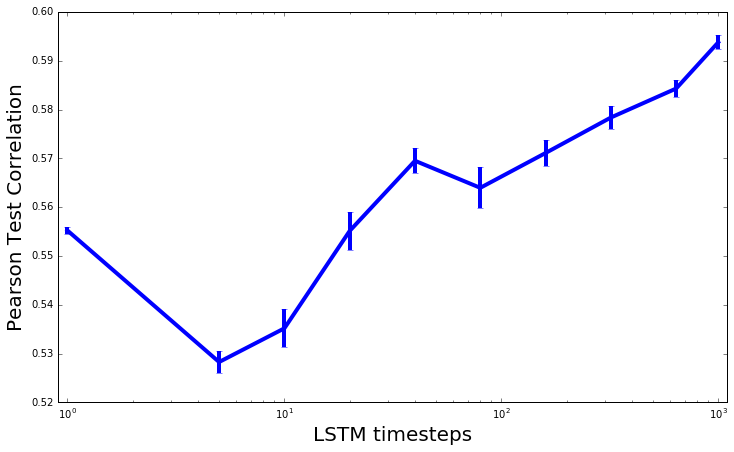

In [12]:
fig = plt.gcf()
fig.set_size_inches((12,7))
plt.errorbar(timesteps, means, yerr=stderrs, linewidth=4)
plt.xscale('log')
plt.xlim([.9, 1100])
plt.xlabel('LSTM timesteps', fontsize=20)
plt.ylabel('Pearson Test Correlation', fontsize=20)

# How does LSTM performance vary as time progresses within a sample?  

We're going to explore the performance of the fixed convnet - LSTM model within a sample as time progresses.

In [ ]:
from 

In [15]:
# model trained on natural scenes
white_model_path = expanduser('~/Dropbox/deep-retina/saved/lenna.nirum/2015-12-13 23.20.03 convnet/')
white_weight_name = 'epoch097_iter06950_weights.h5'

# LSTM model
lstm_path = '/Users/lmcintosh/data/deep-retina/saved/lenna.salamander/2016-01-19 02.41.03 fixedlstm/'
lstm_weight_name = 'epoch033_iter00100_weights.h5'